In [98]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.catch_warnings 

import torchvision

import cv2 as cv
import os

data_path = 'dataset\input_images'

In [99]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100  # edge high threshold in Canny algorithm
                self.edge_high_threshold = 220  # edge high threshold in Canny algorithm
                self.dark_spot_threshold = 150  # pixels brighter than this are ignored
                self.linelength_threshold = 10  # lines shorter than this are ignored
                self.divergence_threshold = 0.25  # Should be farther away from image center than this threshold to be considered hair
                self.patchiness_threshold = 0.15  # Should be more widespread than this threshold to be considered hair
                self.interp_win = 20
        cfg = CFG()

    fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for this_ax in ax.ravel():
        this_ax.set_axis_off()

    img_filtered_all = []
    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]

        # -------------------------------------------------------- Check if input is RGB
        plt.sca(ax[image_ind, 0])

        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')

        skip_flag = 0

        # -------------------------------------------------------- The Edges
        plt.sca(ax[image_ind, 1])

        kernel = np.ones((3, 3), np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel)
        img_filt = np.where(img_filt > 15, img_filt, 0)

        kernel = np.ones((4, 4), np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)

        plt.imshow(img_filt, cmap='gray')
        plt.title('BlachHat')

        # -------------------------------------------------------- Edges within dark spots of image
        plt.sca(ax[image_ind, 2])

        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4, 4), np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)

        img_filt = img_filt * dark_spots

        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')

        # -------------------------------------------------------- The Lines detected from the Edges
        plt.sca(ax[image_ind, 3])

        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]

            # exclude short lines
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2]) ** 2 + (line[1] - line[3]) ** 2)

                if (line_length < cfg.linelength_threshold):
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append((x, y))

        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)

        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

        # -------------------------------------------------------- The Final mask (from only reasonably longer lines)
        plt.sca(ax[image_ind, 4])

        if skip_flag == 1:
            Mask = np.zeros(image_size)

        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1

            kernel = np.ones((3, 3), np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)

            # -------- Check if it is patchy enough (otherwise it's false positives; because hair is likely patchy)
            i, j = np.where(Mask != 0)

            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)

            else:
                x_patchiness = np.std(j) / Mask.shape[1]
                y_patchiness = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt(x_patchiness * y_patchiness)
                divergence = np.max([x_divergence, y_divergence])

                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)

        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

        # -------------------------------------------------------- Interpolate the hairs
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig

        else:
            Mask_temp = 1 - 2 * Mask  # Positive if area is good, Negative if area is bad
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range(img_orig.shape[-1]):
                    img_masked = np.squeeze(img_orig[:, :, channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds,
                                                              interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)

        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        img_filtered_all.append(img_filtered)

    return img_filtered_all


def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds):
        if (i >= interp_win) or (j >= interp_win):
            template = img_masked[i: i + 2 * interp_win, j: j + 2 * interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i - 2 * interp_win: i, j - 2 * interp_win: j].flatten()
        else:
            template = img_masked[i - interp_win: i + interp_win, j - interp_win: j + interp_win].flatten()

        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median(template)
        
    return img_masked


def fill_line(x, y, step=1):
    points = []
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1] - x[0]))
        ys = y[0] + m * (xs - x[0])
    return xs.astype(int), ys.astype(int)


# Example usage:
# Load your images into 'images' variable as a list or an array
# images = [cv.imread("image1.jpg"), cv.imread("image2.jpg"), ...]
# Call the function
# remove_hair(images)


[array([[[131, 131, 221],
         [126, 128, 222],
         [127, 129, 223],
         ...,
         [138, 134, 229],
         [138, 136, 226],
         [139, 135, 230]],
 
        [[129, 129, 223],
         [126, 130, 225],
         [133, 132, 228],
         ...,
         [137, 135, 225],
         [136, 136, 226],
         [135, 134, 226]],
 
        [[126, 128, 222],
         [131, 129, 229],
         [134, 130, 231],
         ...,
         [132, 136, 224],
         [133, 136, 227],
         [134, 137, 228]],
 
        ...,
 
        [[125, 118, 209],
         [126, 119, 210],
         [126, 121, 212],
         ...,
         [128, 140, 210],
         [130, 141, 209],
         [128, 139, 207]],
 
        [[118, 116, 205],
         [121, 119, 208],
         [124, 120, 209],
         ...,
         [129, 142, 210],
         [131, 144, 212],
         [130, 143, 211]],
 
        [[115, 116, 207],
         [116, 120, 209],
         [118, 120, 208],
         ...,
         [125, 143, 208],
  

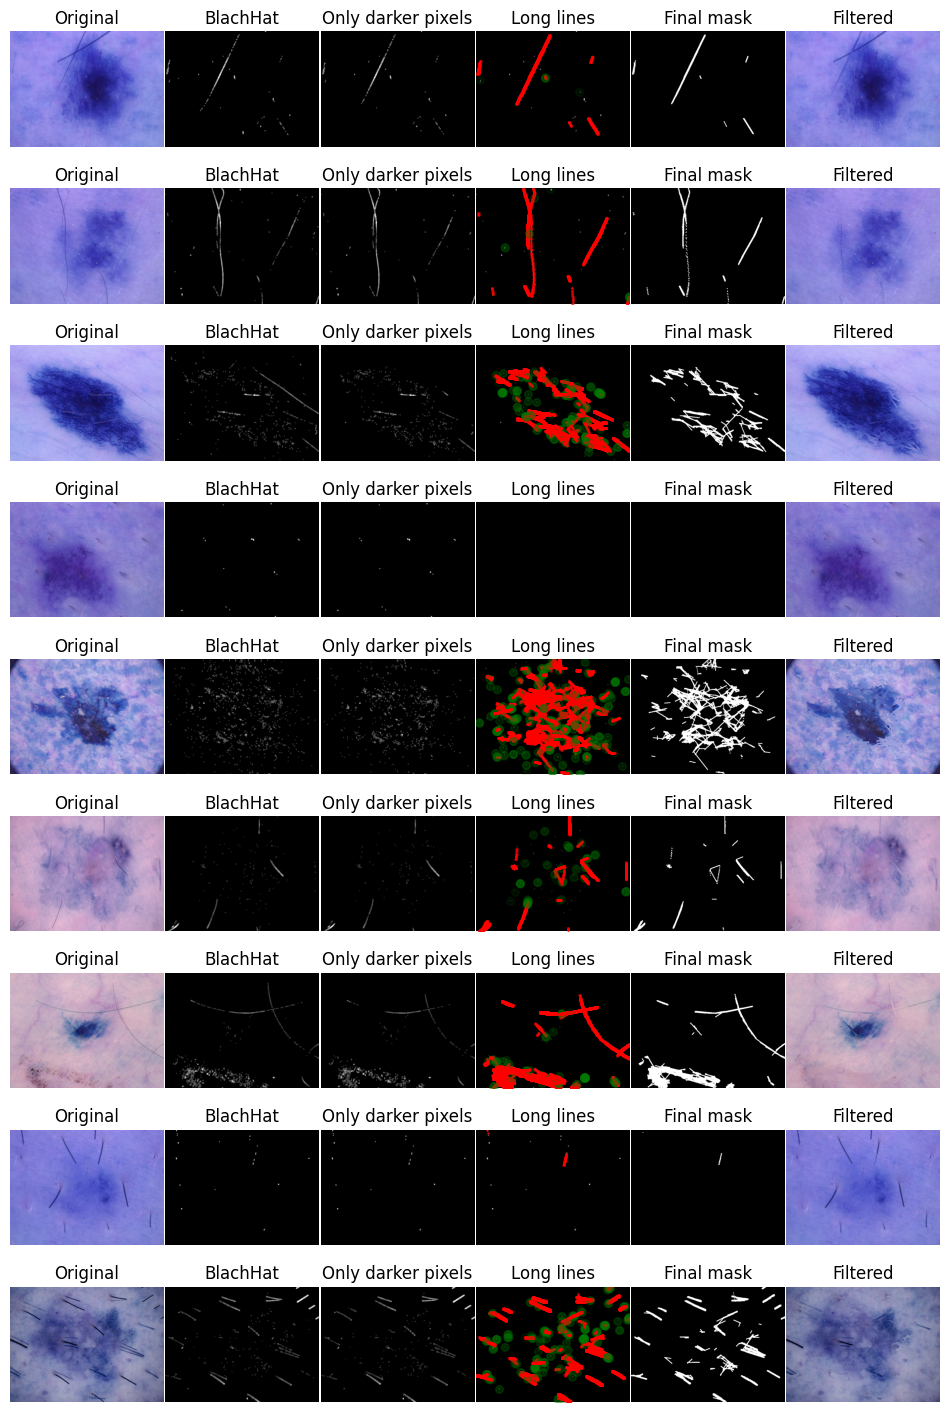

In [100]:
import os
import cv2
import numpy as np

# Specify the directory containing all images
image_dir = 'dataset/input_images'

# Get all filenames in the directory
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]

# Load images using OpenCV and store them in a list
images = [cv2.imread(file) for file in image_files]

# Convert color space from BGR to RGB
images_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

# Swap red and blue channels
for image in images_rgb:
    image[:, :, [0, 2]] = image[:, :, [2, 0]]

# Now you have all the images loaded and converted to RGB with swapped channels
# You can print the list of images to see the output

# Pass the images_rgb list directly to remove_hair function
remove_hair(images_rgb)
